In [2]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt

import utils.compressed_sensing as cs
import torch.nn as nn
import torch

import os
import torch.nn.functional as F

from utils.dataset import anatomy_data
from utils.general import init_seeds, normalized_cross_correlation, CudaCKA
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from utils.model import LDA_vis, Universal_LDA_vis


In [6]:
mask = scio.loadmat("data/mask/mask_50.mat")

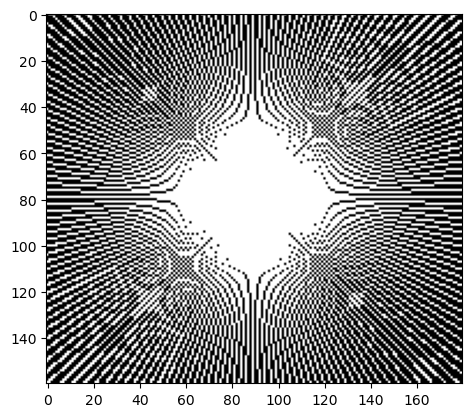

In [9]:
plt.imshow(mask['mask_50'], cmap='gray')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 2

brain_dataset = anatomy_data('data/brain/brain_singlecoil_test.mat', acc=5, n=200, mask='radial')
brain_loader = DataLoader(brain_dataset, batch_size=batch_size, shuffle=True)

knee_dataset = anatomy_data('data/knee/knee_singlecoil_test.mat', acc=5, n=200, mask='radial')
knee_loader = DataLoader(knee_dataset, batch_size=batch_size, shuffle=True)

## Undersampled MRI PSNR

In [29]:
PSNR_list = []
with torch.no_grad():
    for i, data in enumerate(brain_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        
        # forward pass
        #output, _ = model1(im_und, k_und, mask)
        #output = torch.abs(output[-1]).clamp(0, 1)
        im_und = torch.abs(im_und).clamp(0,1)
        img_gnd = torch.abs(img_gnd)
        
        for j in range(batch_size):
            p = psnr(np.abs(im_und[j].squeeze().cpu().detach().numpy()), img_gnd[j].squeeze().cpu().detach().numpy(), data_range=1)
            PSNR_list.append(p)
            print("psnr: ", p)
        
        
print("average psnr: ", np.mean(PSNR_list))

psnr:  25.729324463408553
psnr:  23.546488072195018
psnr:  25.52231240623822
psnr:  23.50201513168645
psnr:  24.212487522805553
psnr:  23.953855963589792
psnr:  24.37770711816093
psnr:  23.160995381967577
psnr:  21.727315337289067
psnr:  22.62775307914929
psnr:  22.461928370915018
psnr:  22.466405490318557
psnr:  27.289528675696005
psnr:  26.574622274169105
psnr:  25.113695288308598
psnr:  23.59970158740935
psnr:  24.480687005681023
psnr:  21.81277908867994
psnr:  23.16986403709526
psnr:  24.502023031890616
psnr:  25.044567407001736
psnr:  24.438264848002248
psnr:  24.238401300854512
psnr:  24.680669300649814
psnr:  24.600014031282264
psnr:  25.37965293663964
psnr:  24.27558748719352
psnr:  23.25597336763782
psnr:  24.658675116583147
psnr:  24.96289953879802
psnr:  24.85145795253817
psnr:  25.367651776009545
psnr:  22.534636273595975
psnr:  21.60705555262922
psnr:  23.707676439311726
psnr:  25.461548308142355
psnr:  21.894979096031413
psnr:  22.445668862039962
psnr:  25.902696755717475

## Independent Model Reconstruction Quality

In [9]:
model1 = LDA_vis(n_block=15).cuda() # brain
model2 = LDA_vis(n_block=15).cuda() # knee

model1.load_state_dict(torch.load('universal_LDA/brain/checkpoints_5_sampling_radial/checkpoint.pth'))
model2.load_state_dict(torch.load('universal_LDA/knee/checkpoints_5_sampling_radial/checkpoint.pth'))

<All keys matched successfully>

### Brain LDA

In [10]:
PSNR_list = []
with torch.no_grad():
    for i, data in enumerate(brain_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        
        # forward pass
        output, _ = model1(im_und, k_und, mask)
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        
        for j in range(batch_size):
            p = psnr(np.abs(output[j].squeeze().cpu().detach().numpy()), img_gnd[j].squeeze().cpu().detach().numpy(), data_range=1)
            PSNR_list.append(p)
            print("psnr: ", p)
        
        
print("average psnr: ", np.mean(PSNR_list))

psnr:  44.064355655783054
psnr:  42.57566029052786
psnr:  40.3898454633348
psnr:  43.904738653184275
psnr:  43.984768156508245
psnr:  31.060329527127564
psnr:  40.844031840606704
psnr:  37.320951855163635
psnr:  40.97808668214941
psnr:  38.590041233388305
psnr:  38.729995900042425
psnr:  32.40481533682932
psnr:  44.936812405093924
psnr:  43.23503403194984
psnr:  39.842321332436214
psnr:  39.759374800271154
psnr:  42.24132520218159
psnr:  38.66413610654352
psnr:  38.72673723166511
psnr:  40.95164600702201
psnr:  40.8793489934142
psnr:  40.4666992769027
psnr:  39.284248029678814
psnr:  39.84714116783294
psnr:  38.201876686611335
psnr:  39.57994393941158
psnr:  41.930062290752176
psnr:  42.935666873136
psnr:  39.45233415310054
psnr:  41.59187554692427
psnr:  43.32856511767218
psnr:  43.73759188762254
psnr:  39.72194823365761
psnr:  42.189318060520634
psnr:  42.2558933873217
psnr:  42.53650663154823
psnr:  40.75408561725971
psnr:  38.071958395314674
psnr:  44.96743793043976
psnr:  40.08105

### Knee LDA

In [32]:
PSNR_list = []
model2.set_PhaseNo(5)
with torch.no_grad():
    for i, data in enumerate(knee_loader):
        # undersampled image, k-space, mask, original image, original k-space
        im_und, k_und, mask, img_gnd, k_gnd = data
        # print(im_und.shape, k_und.shape, mask.shape, img_gnd.shape, k_gnd.shape)
        
        im_und = im_und.to(device)
        k_und = k_und.to(device)
        mask = mask.to(device)
        img_gnd = img_gnd.to(device)
        k_gnd = k_gnd.to(device)    
        
        # forward pass
        output, _ = model2(im_und, k_und, mask)
        output = torch.abs(output[-1]).clamp(0, 1)
        img_gnd = torch.abs(img_gnd)
        
        for j in range(batch_size):
            p = psnr(np.abs(output[j].squeeze().cpu().detach().numpy()), img_gnd[j].squeeze().cpu().detach().numpy(), data_range=1)
            PSNR_list.append(p)
            print("psnr: ", p)
        
        
print("average psnr: ", np.mean(PSNR_list))

psnr:  33.433594605003066
psnr:  31.43382505475536
psnr:  30.804222635380754
psnr:  28.591874516359713


psnr:  32.21293962857673
psnr:  31.843680962753652
psnr:  29.90208996399489
psnr:  28.181921876995734
psnr:  28.181566946026265
psnr:  34.05126836732988
psnr:  32.180342776295426
psnr:  28.763322415183985
psnr:  32.431092731121076
psnr:  33.18092198769457
psnr:  31.070335556998046
psnr:  30.6039205331888
psnr:  28.35262558738012
psnr:  29.91554972741593
psnr:  32.69250869541998
psnr:  27.24972940228409
psnr:  29.82474632327046
psnr:  30.4364968793521
psnr:  29.270829543315546
psnr:  30.983848899781815
psnr:  30.396812004595297
psnr:  31.403621672230653
psnr:  34.17372306801863
psnr:  30.49438072048444
psnr:  32.37909976072268
psnr:  28.489139580578872
psnr:  30.470583881830166
psnr:  29.94461206565277
psnr:  28.038360071024897
psnr:  30.37113323739259
psnr:  35.11579830582847
psnr:  32.82238691101921
psnr:  32.27559873373244
psnr:  29.32113931304885
psnr:  34.186309155349065
psnr:  30.714132866796632
psnr:  29.490831047828916
psnr:  31.93858266891172
psnr:  29.118520163255667
psnr:  33

(-0.5, 255.5, 255.5, -0.5)

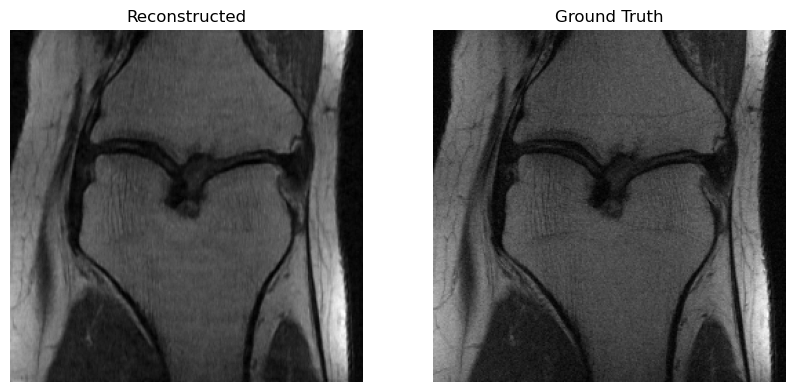

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.abs(output[1].squeeze().cpu().detach().numpy()), cmap='gray')
ax[1].imshow(img_gnd[1].squeeze().cpu().detach().numpy(), cmap='gray')

ax[0].set_title('Reconstructed')
ax[1].set_title('Ground Truth')

ax[0].axis('off')
ax[1].axis('off')

# compare g1(x2) and g2(x2), g2(x1) and g1(x1)

In [3]:
brain_im_und, brain_k_und, brain_mask, brain_img_gnd, brain_k_gnd = next(iter(brain_loader))
knee_im_und, knee_k_und, knee_mask, knee_img_gnd, knee_k_gnd = next(iter(knee_loader))

with torch.no_grad():
    _, g11 = model1(brain_im_und.to(device), brain_k_und.to(device), brain_mask.to(device))
    _, g12 = model1(knee_im_und.to(device), knee_k_und.to(device), knee_mask.to(device))

    _, g21 = model2(brain_im_und.to(device), brain_k_und.to(device), brain_mask.to(device))
    _, g22 = model2(knee_im_und.to(device), knee_k_und.to(device), knee_mask.to(device))

NameError: name 'model1' is not defined

In [5]:
def get_fnorm(feature):
    return np.abs((torch.square(feature[-1][-1][0]).sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5)

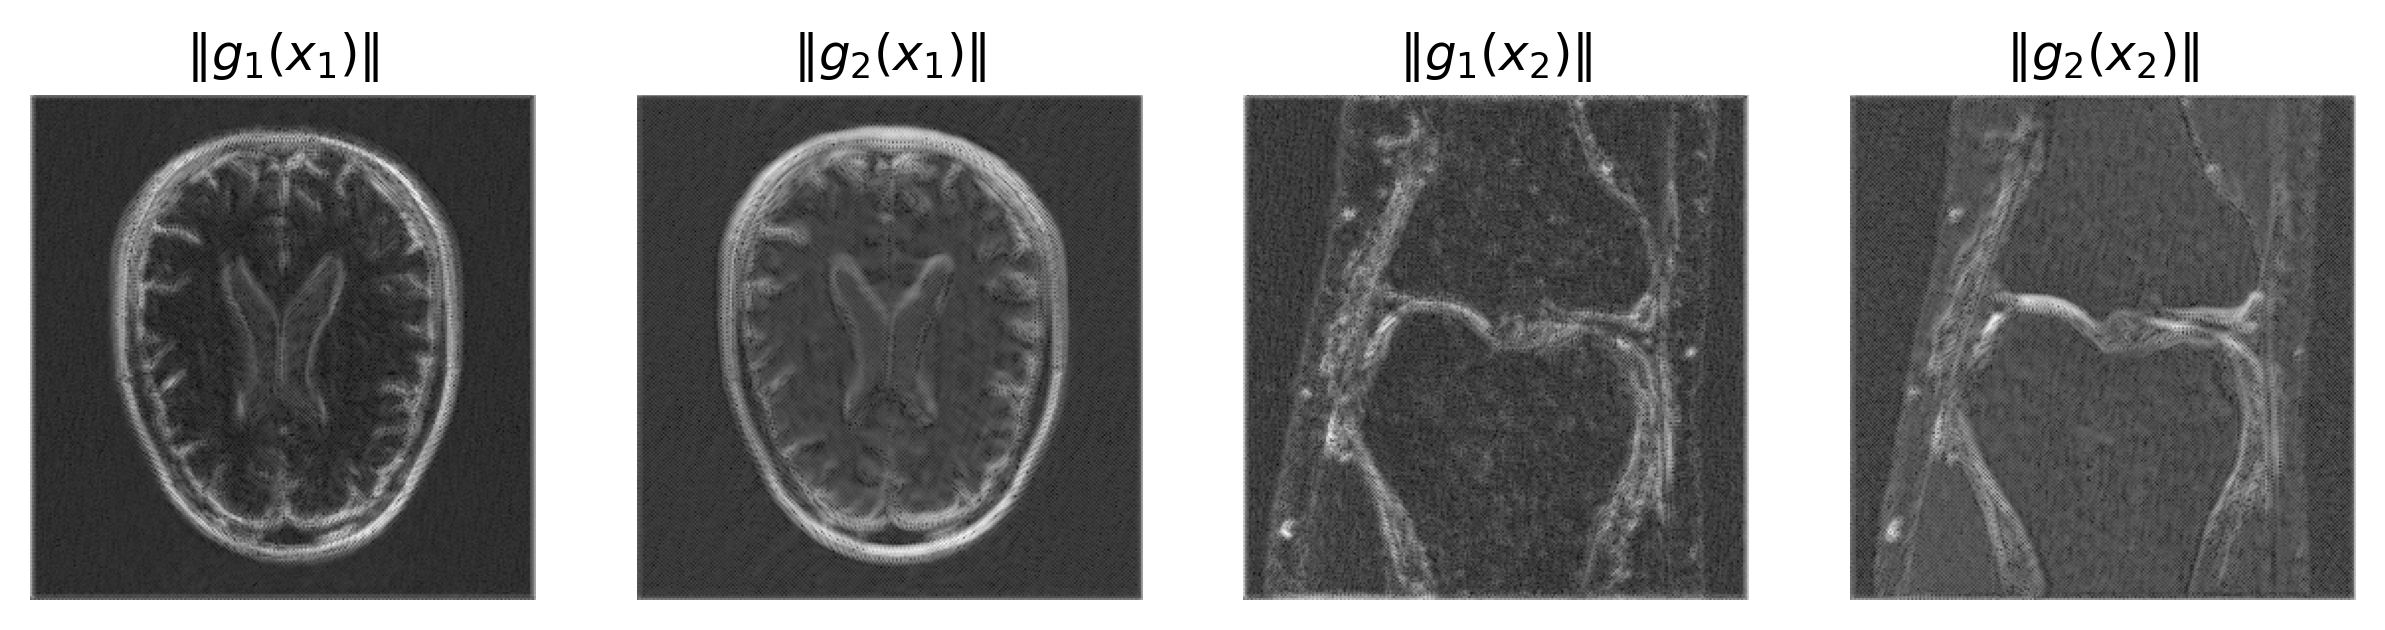

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=300)

norm11 = get_fnorm(g11)#np.abs((torch.square(g11[-1][-1][0]).sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5)
norm12 = get_fnorm(g12)#np.abs((torch.square(g12[-1][-1][0]).sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5)
norm21 = get_fnorm(g21)#np.abs((torch.square(g21[-1][-1][0]).sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5)
norm22 = get_fnorm(g22)#np.abs((torch.square(g22[-1][-1][0]).sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5)
ax[0].imshow(norm11**0.5, cmap='gray')
ax[2].imshow(norm12**0.5, cmap='gray')
ax[1].imshow(norm21**0.5, cmap='gray')
ax[3].imshow(norm22**0.5, cmap='gray')

ax[0].set_title('$\|g_{1}(x_1)\|$')
ax[2].set_title('$\|g_{1}(x_2)\|$')
ax[1].set_title('$\|g_{2}(x_1)\|$')
ax[3].set_title('$\|g_{2}(x_2)\|$')

for a in ax:
    a.axis('off')


# save figure
#plt.savefig('figures/brain_knee.pdf', bbox_inches='tight', dpi=300)

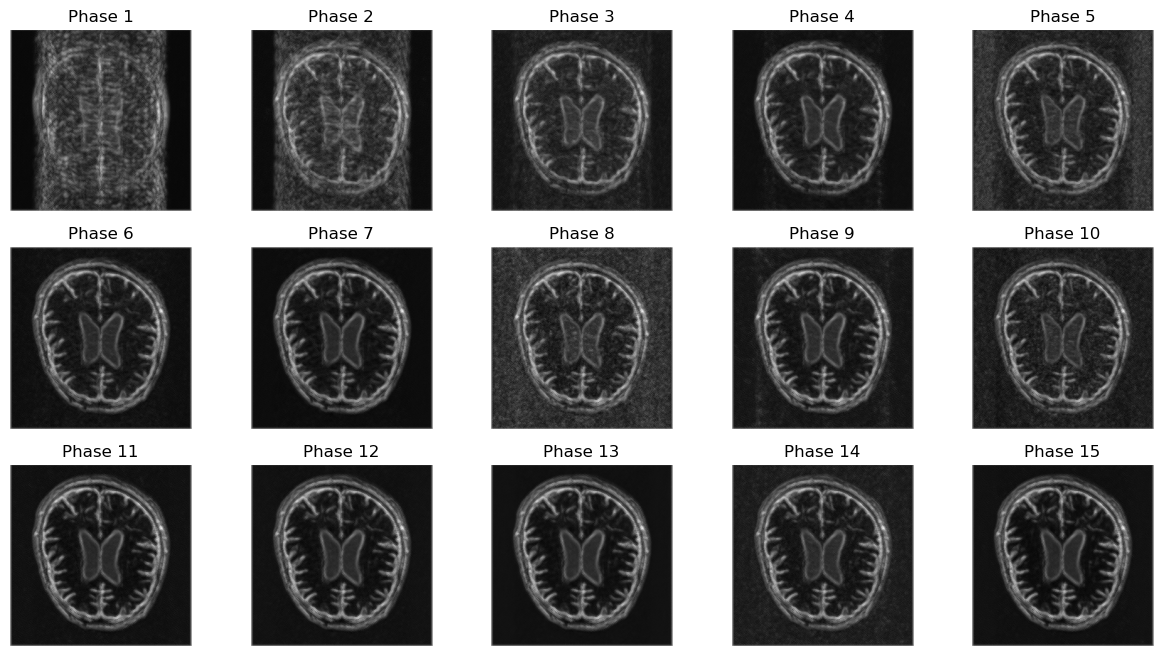

In [205]:
#fig, ax = plt.subplots(3, 5, figsize=(15, 15), dpi=300)
fig, ax = plt.subplots(3, 5, figsize=(15, 8))
for i in range(15):
    #ax[i//5, i%5].imshow(torch.abs(torch.abs(g11[i][-1]).sum(dim=1,keepdim=True))[0].squeeze().cpu().numpy(), cmap='gray')
    ax[i//5, i%5].imshow(torch.abs(torch.abs(g11[i][-1]).sum(dim=1,keepdim=True))[0].squeeze().cpu().numpy()**0.5, cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title('Phase %d' % (i+1))

In [39]:
g11[-1][-1][0].sum(dim=0, keepdim=True).shape

torch.Size([1, 256, 256])

# Universal Model vs Anatomy Specific Models

In [5]:
anatomies = ['brain', 'knee']
n_phase = 15
model = Universal_LDA_vis(n_block=n_phase, anatomies=anatomies)
model.to(device)
model.load_state_dict(torch.load('universal_LDA/universal/checkpoints_5_sampling_radial/checkpoint.pth')['state_dict'])

<All keys matched successfully>

In [ ]:
brain_im_und, brain_k_und, brain_mask, brain_img_gnd, brain_k_gnd = next(iter(brain_loader))
knee_im_und, knee_k_und, knee_mask, knee_img_gnd, knee_k_gnd = next(iter(knee_loader))

with torch.no_grad():
    _, g1, hg1 = model(brain_im_und.to(device), brain_k_und.to(device), brain_mask.to(device), anatomies[0])
    _, g2, hg2 = model(knee_im_und.to(device), knee_k_und.to(device), knee_mask.to(device), anatomies[1])

In [6]:
brain_im_und, brain_k_und, brain_mask, brain_img_gnd, brain_k_gnd = next(iter(brain_loader))
knee_im_und, knee_k_und, knee_mask, knee_img_gnd, knee_k_gnd = next(iter(knee_loader))

with torch.no_grad():
    _, g1, hg1 = model(brain_img_gnd.to(device), brain_k_gnd.to(device), brain_mask.to(device), anatomies[0])
    _, g2, hg2 = model(knee_img_gnd.to(device), knee_k_gnd.to(device), knee_mask.to(device), anatomies[1])

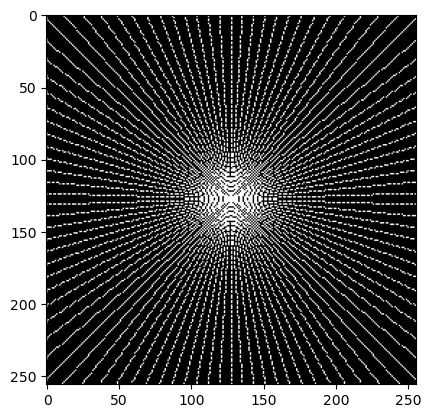

In [4]:
plt.imshow(brain_mask.squeeze().numpy()[0], cmap='gray')

In [6]:
model1 = LDA_vis(n_block=15).cuda() # brain
model2 = LDA_vis(n_block=15).cuda() # knee

model1.load_state_dict(torch.load('universal_LDA/brain/checkpoints_5_sampling_radial/checkpoint.pth'))
model2.load_state_dict(torch.load('universal_LDA/knee/checkpoints_5_sampling_radial/checkpoint.pth'))

<All keys matched successfully>

In [7]:
with torch.no_grad():
    _, g11 = model1(brain_img_gnd.to(device), brain_k_gnd.to(device), brain_mask.to(device))
    _, g12 = model1(knee_img_gnd.to(device), knee_k_gnd.to(device), knee_mask.to(device))

    _, g21 = model2(brain_img_gnd.to(device), brain_k_gnd.to(device), brain_mask.to(device))
    _, g22 = model2(knee_img_gnd.to(device), knee_k_gnd.to(device), knee_mask.to(device))

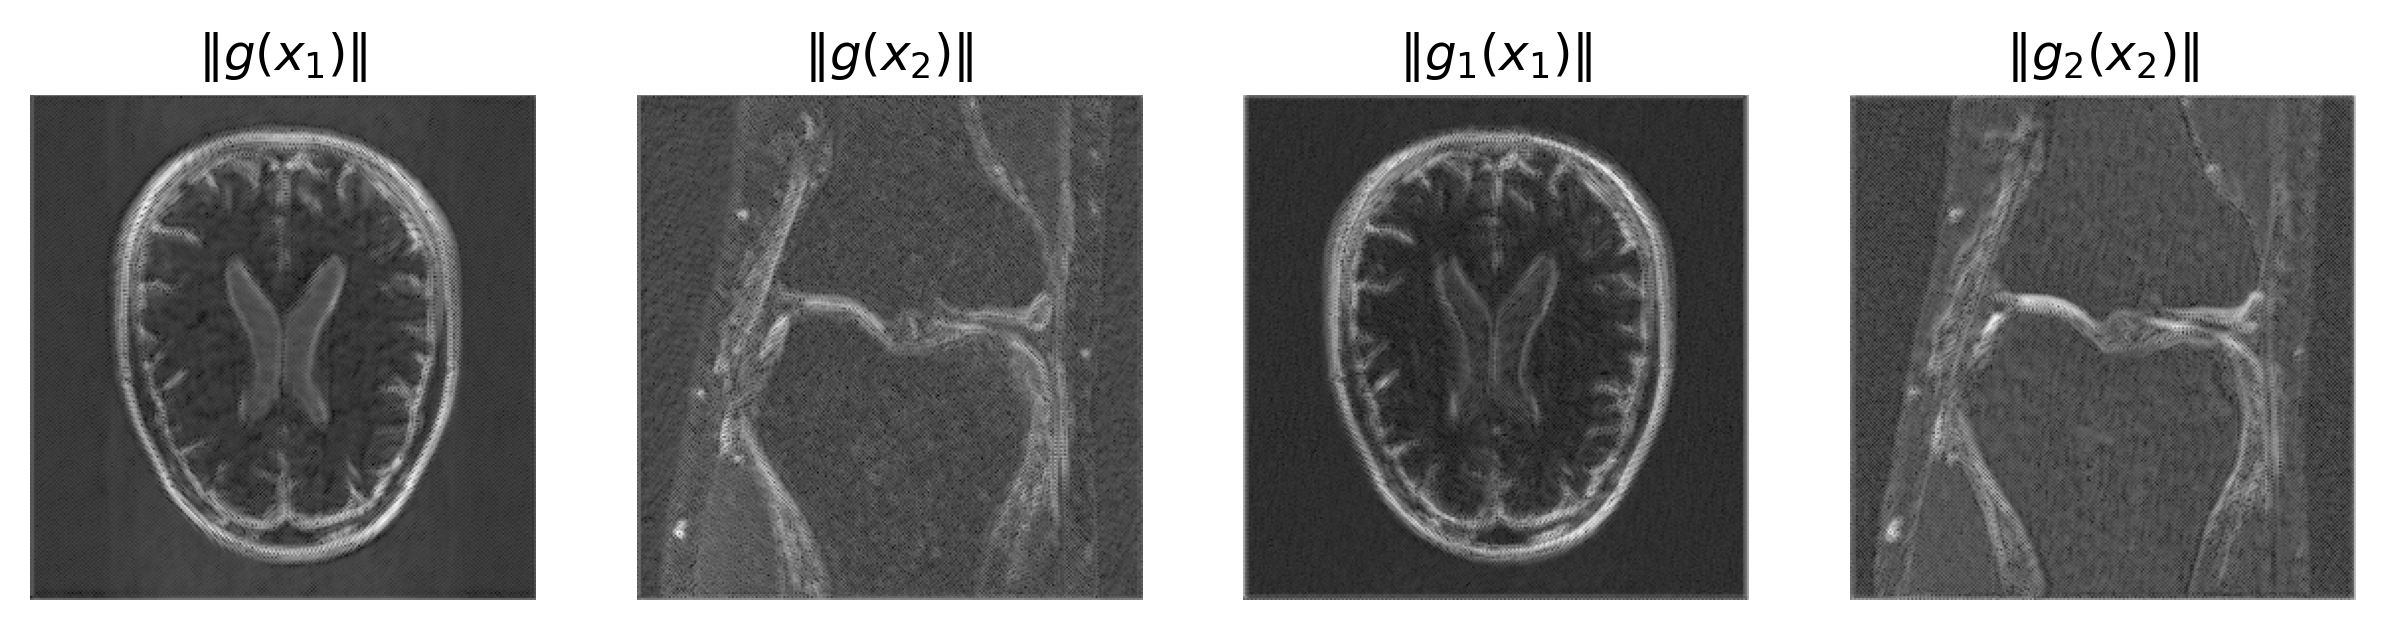

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=300)

conv_idx = 3

norm1 = np.abs((torch.square(g1[-1][conv_idx][0]).sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5)
#norm1 = np.abs(g1[-1][conv_idx][0].norm(2,dim=0).squeeze().cpu().detach().numpy())
norm2 = np.abs((torch.square(g2[-1][conv_idx][0]).sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5)
#norm2 = np.abs(g2[-1][conv_idx][0].norm(2,dim=0).squeeze().cpu().detach().numpy())
norm11 = np.abs((torch.square(g11[-1][conv_idx][0]).sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5)
#norm11 = np.abs(g11[-1][conv_idx][0].norm(2,dim=0).squeeze().cpu().detach().numpy())
norm22 = np.abs((torch.square(g22[-1][conv_idx][0]).sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5)
#norm22 = np.abs(g22[-1][conv_idx][0].norm(2,dim=0).squeeze().cpu().detach().numpy())

ax[0].imshow(norm1**0.5, cmap='gray')
ax[1].imshow(norm2**0.5, cmap='gray')
ax[2].imshow(norm11**0.5, cmap='gray')
ax[3].imshow(norm22**0.5, cmap='gray')

ax[0].set_title('$\|g(x_1)\|$')
ax[1].set_title('$\|g(x_2)\|$')
ax[2].set_title('$\|g_1(x_1)\|$')
ax[3].set_title('$\|g_2(x_2)\|$')

for a in ax:
    a.axis('off')

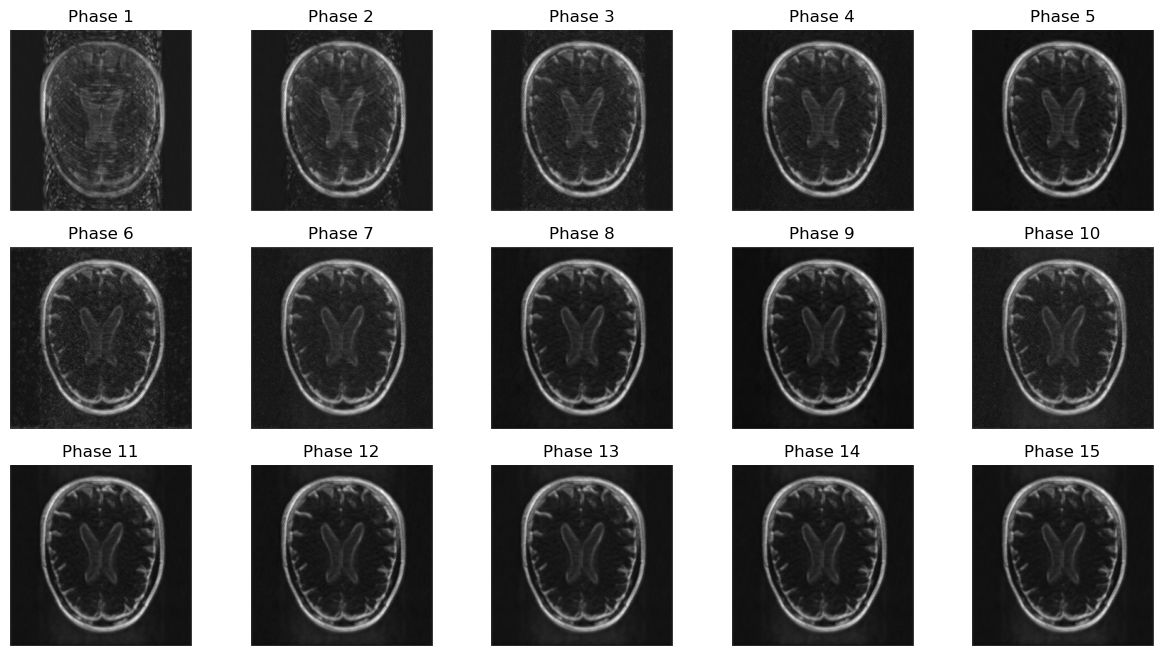

In [10]:
#fig, ax = plt.subplots(3, 5, figsize=(15, 15), dpi=300)
fig, ax = plt.subplots(3, 5, figsize=(15, 8))
for i in range(15):
    #ax[i//5, i%5].imshow(torch.abs(torch.abs(g11[i][-1]).sum(dim=1,keepdim=True))[0].squeeze().cpu().numpy(), cmap='gray')
    ax[i//5, i%5].imshow(torch.abs(torch.abs(g1[i][-1]).sum(dim=1,keepdim=True))[0].squeeze().cpu().numpy()**0.5, cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title('Phase %d' % (i+1))

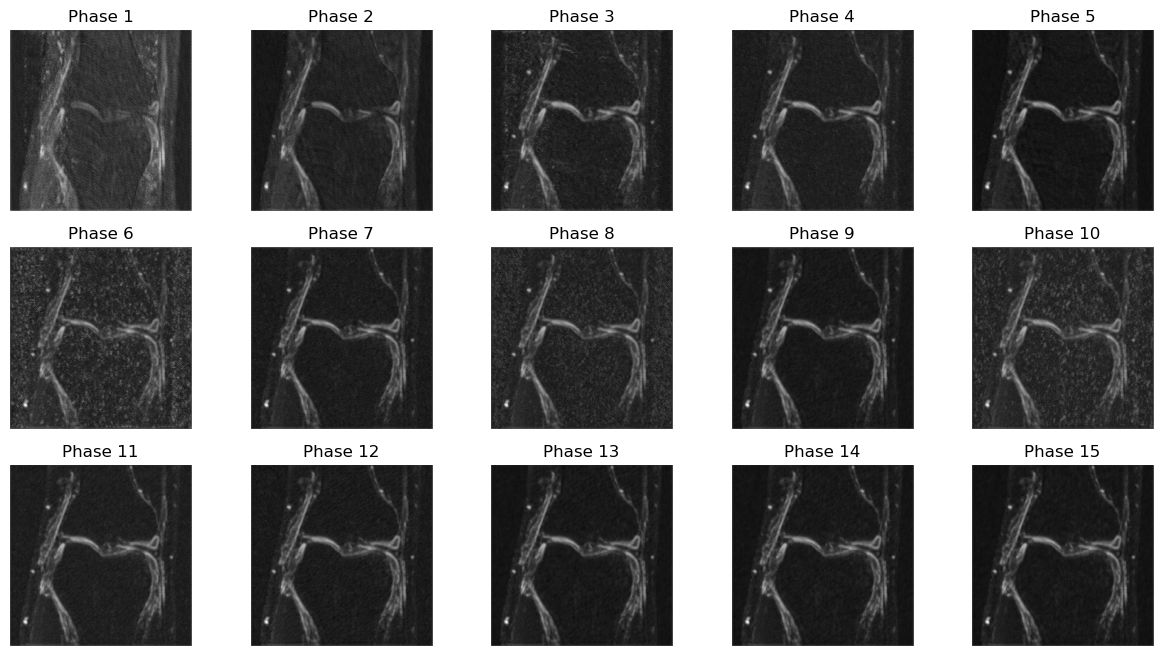

In [11]:
#fig, ax = plt.subplots(3, 5, figsize=(15, 15), dpi=300)
fig, ax = plt.subplots(3, 5, figsize=(15, 8))
for i in range(15):
    #ax[i//5, i%5].imshow(torch.abs(torch.abs(g11[i][-1]).sum(dim=1,keepdim=True))[0].squeeze().cpu().numpy(), cmap='gray')
    ax[i//5, i%5].imshow(torch.abs(torch.abs(g2[i][-1]).sum(dim=1,keepdim=True))[0].squeeze().cpu().numpy()**0.5, cmap='gray')
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title('Phase %d' % (i+1))

In [41]:
print(hg1[-1].shape)
print(g2[-1][-1].shape)
print(len(g2[-1]))

torch.Size([1, 256, 256])
torch.Size([2, 16, 256, 256])
4


In [57]:
# so far we have
# g1
# g2
# g11
# g22
# hg1
# hg2
print(hg1[0].shape, g11[0][0].shape)
cuda_cka = CudaCKA(device)
for i in range(15):
    g1_i = g1[i]
    g11_i = g11[i]
    g2_i = g2[i]
    g22_i = g22[i]
    
    corr_g1_g11 = 0
    corr_g2_g22 = 0
    
    cka_g1_g11 = 0
    
    for j in range(4):
        g1_i_j = torch.abs(torch.square(g1_i[j]).sum(dim=1, keepdim=True))[0].unsqueeze(0)
        g2_i_j = torch.abs(torch.square(g2_i[j]).sum(dim=1, keepdim=True))[0].unsqueeze(0)
        g11_i_j = torch.abs(torch.square(g11_i[j]).sum(dim=1, keepdim=True))[0].unsqueeze(0)
        g22_i_j = torch.abs(torch.square(g22_i[j]).sum(dim=1, keepdim=True))[0].unsqueeze(0)
        corr_g1_g11 += normalized_cross_correlation(g1_i_j, g11_i_j, False).item()
        corr_g2_g22 += normalized_cross_correlation(g2_i_j, g22_i_j, False).item()
        #print(g1_i[j].flatten(start_dim=1).shape)
        # cka_g1_g11 += cuda_cka.kernel_CKA(torch.abs(g1_i[j].flatten(1)), torch.abs(g11_i[j].flatten(1))).item()
        
    hg1_i = torch.abs(torch.square(hg1[i].clone()).sum(dim=1, keepdim=True))[0].unsqueeze(0)
    hg2_i = torch.abs(torch.square(hg2[i].clone()).sum(dim=1, keepdim=True))[0].unsqueeze(0)
    corr_hg1_g11 = normalized_cross_correlation(hg1_i, g11_i_j, False).item()
    corr_hg2_g22 = normalized_cross_correlation(hg2_i, g22_i_j, False).item()
    print("phase", i+1)
    print("correlation between g(x1) and g1(x1)",corr_g1_g11/4)
    print("correlation between g(x2) and g2(x2)",corr_g2_g22/4)
    print("correlation between h1g(x1) and g1(x1)",corr_hg1_g11)
    print("correlation between h2g(x2) and g2(x2)",corr_hg2_g22)
    
    
    # print("cka between g(x1) and g1(x1)",cka_g1_g11/4)

torch.Size([2, 16, 256, 256]) torch.Size([2, 16, 256, 256])
phase 1
correlation between g(x1) and g1(x1) 0.6437969952821732
correlation between g(x2) and g2(x2) 0.4398830682039261
correlation between h1g(x1) and g1(x1) 0.43002641201019287
correlation between h2g(x2) and g2(x2) 0.27220261096954346
cka between g(x1) and g1(x1) 1.0
phase 2
correlation between g(x1) and g1(x1) 0.6655306220054626
correlation between g(x2) and g2(x2) 0.45289018005132675
correlation between h1g(x1) and g1(x1) 0.5765024423599243
correlation between h2g(x2) and g2(x2) 0.3029680848121643
cka between g(x1) and g1(x1) 1.0
phase 3
correlation between g(x1) and g1(x1) 0.6941287219524384
correlation between g(x2) and g2(x2) 0.4378494992852211
correlation between h1g(x1) and g1(x1) 0.6085337400436401
correlation between h2g(x2) and g2(x2) 0.32518792152404785
cka between g(x1) and g1(x1) 1.0
phase 4
correlation between g(x1) and g1(x1) 0.7037344425916672
correlation between g(x2) and g2(x2) 0.45501864701509476
correlat

# test for x* version

In [9]:
# so far we have
# g1
# g2
# g11
# g22
# hg1
# hg2
print(hg1[0].shape, g11[0][0].shape)
cuda_cka = CudaCKA(device)
for i in range(15):
    g1_i = g1[i]
    g11_i = g11[i]
    g2_i = g2[i]
    g22_i = g22[i]
    
    corr_g1_g11 = 0
    corr_g2_g22 = 0
    
    cka_g1_g11 = 0
    
    for j in range(4):
        g1_i_j = torch.abs(torch.square(g1_i[j]).sum(dim=1, keepdim=True))[0].unsqueeze(0)
        g2_i_j = torch.abs(torch.square(g2_i[j]).sum(dim=1, keepdim=True))[0].unsqueeze(0)
        g11_i_j = torch.abs(torch.square(g11_i[j]).sum(dim=1, keepdim=True))[0].unsqueeze(0)
        g22_i_j = torch.abs(torch.square(g22_i[j]).sum(dim=1, keepdim=True))[0].unsqueeze(0)
        corr_g1_g11 += normalized_cross_correlation(g1_i_j, g11_i_j, False).item()
        corr_g2_g22 += normalized_cross_correlation(g2_i_j, g22_i_j, False).item()
        #print(g1_i[j].flatten(start_dim=1).shape)
        # cka_g1_g11 += cuda_cka.kernel_CKA(torch.abs(g1_i[j].flatten(1)), torch.abs(g11_i[j].flatten(1))).item()
        
    hg1_i = torch.abs(torch.square(hg1[i].clone()).sum(dim=1, keepdim=True))[0].unsqueeze(0)
    hg2_i = torch.abs(torch.square(hg2[i].clone()).sum(dim=1, keepdim=True))[0].unsqueeze(0)
    corr_hg1_g11 = normalized_cross_correlation(hg1_i, g11_i_j, False).item()
    corr_hg2_g22 = normalized_cross_correlation(hg2_i, g22_i_j, False).item()
    print("phase", i+1)
    print("correlation between g(x1) and g1(x1)",corr_g1_g11/4)
    print("correlation between g(x2) and g2(x2)",corr_g2_g22/4)
    print("correlation between h1g(x1) and g1(x1)",corr_hg1_g11)
    print("correlation between h2g(x2) and g2(x2)",corr_hg2_g22)
    
    
    # print("cka between g(x1) and g1(x1)",cka_g1_g11/4)

torch.Size([2, 16, 256, 256]) torch.Size([2, 16, 256, 256])
phase 1
correlation between g(x1) and g1(x1) 0.7850116491317749
correlation between g(x2) and g2(x2) 0.7722398191690445
correlation between h1g(x1) and g1(x1) 0.7499375343322754
correlation between h2g(x2) and g2(x2) 0.7497531175613403
phase 2
correlation between g(x1) and g1(x1) 0.7032001912593842
correlation between g(x2) and g2(x2) 0.6627077460289001
correlation between h1g(x1) and g1(x1) 0.7439883351325989
correlation between h2g(x2) and g2(x2) 0.7422212362289429
phase 3
correlation between g(x1) and g1(x1) 0.7074895948171616
correlation between g(x2) and g2(x2) 0.652308888733387
correlation between h1g(x1) and g1(x1) 0.7779974937438965
correlation between h2g(x2) and g2(x2) 0.7448378205299377
phase 4
correlation between g(x1) and g1(x1) 0.7085529938340187
correlation between g(x2) and g2(x2) 0.6629415303468704
correlation between h1g(x1) and g1(x1) 0.7833088636398315
correlation between h2g(x2) and g2(x2) 0.74077928066253

In [70]:
g1_1 = torch.abs(torch.square(g1_i[1]).sum(dim=1, keepdim=True))
g1_2 = torch.abs(torch.square(g1_i[2]).sum(dim=1, keepdim=True))
cuda_cka.kernel_CKA(g1_1.flatten(1), g1_2.flatten(1)).item()

1.0

In [151]:
cuda_cka.linear_CKA(torch.randn(1600,64*64).cuda(), torch.randn(1600,64*64).cuda()).item()

0.7186443209648132

In [13]:
print(normalized_cross_correlation(torch.abs(g2[-1][-1]), torch.abs(g22[-1][-1]),False).item())
print(normalized_cross_correlation(torch.abs(hg2), torch.abs(g22[-1][-1]),False).item())
print(normalized_cross_correlation(torch.abs(hg2), torch.abs(g2[-1][-1]),False).item())

0.30764520168304443
0.15099011361598969
0.18163739144802094


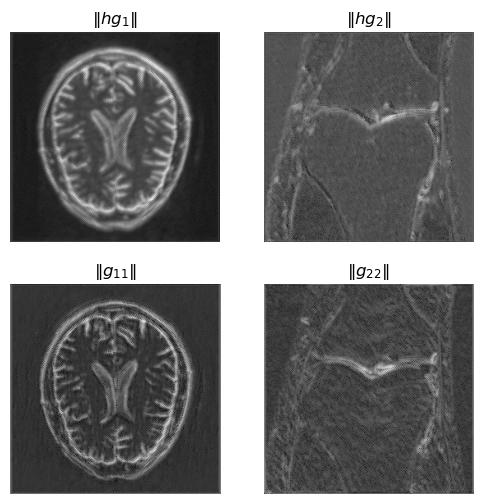

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
conv_idx = 3
ax[0, 0].imshow(np.abs(hg1[-1][0].sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5, cmap='gray')
ax[0, 1].imshow(np.abs(hg2[-1][0].sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5, cmap='gray')
ax[1, 0].imshow(np.abs(g11[-1][conv_idx][0].sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5, cmap='gray')
ax[1, 1].imshow(np.abs(g22[-1][conv_idx][0].sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5, cmap='gray')

ax[0, 0].set_title('$\|hg_{1}\|$')
ax[0, 1].set_title('$\|hg_{2}\|$')
ax[1, 0].set_title('$\|g_{11}\|$')
ax[1, 1].set_title('$\|g_{22}\|$')

for a in ax.flatten():
    a.axis('off')

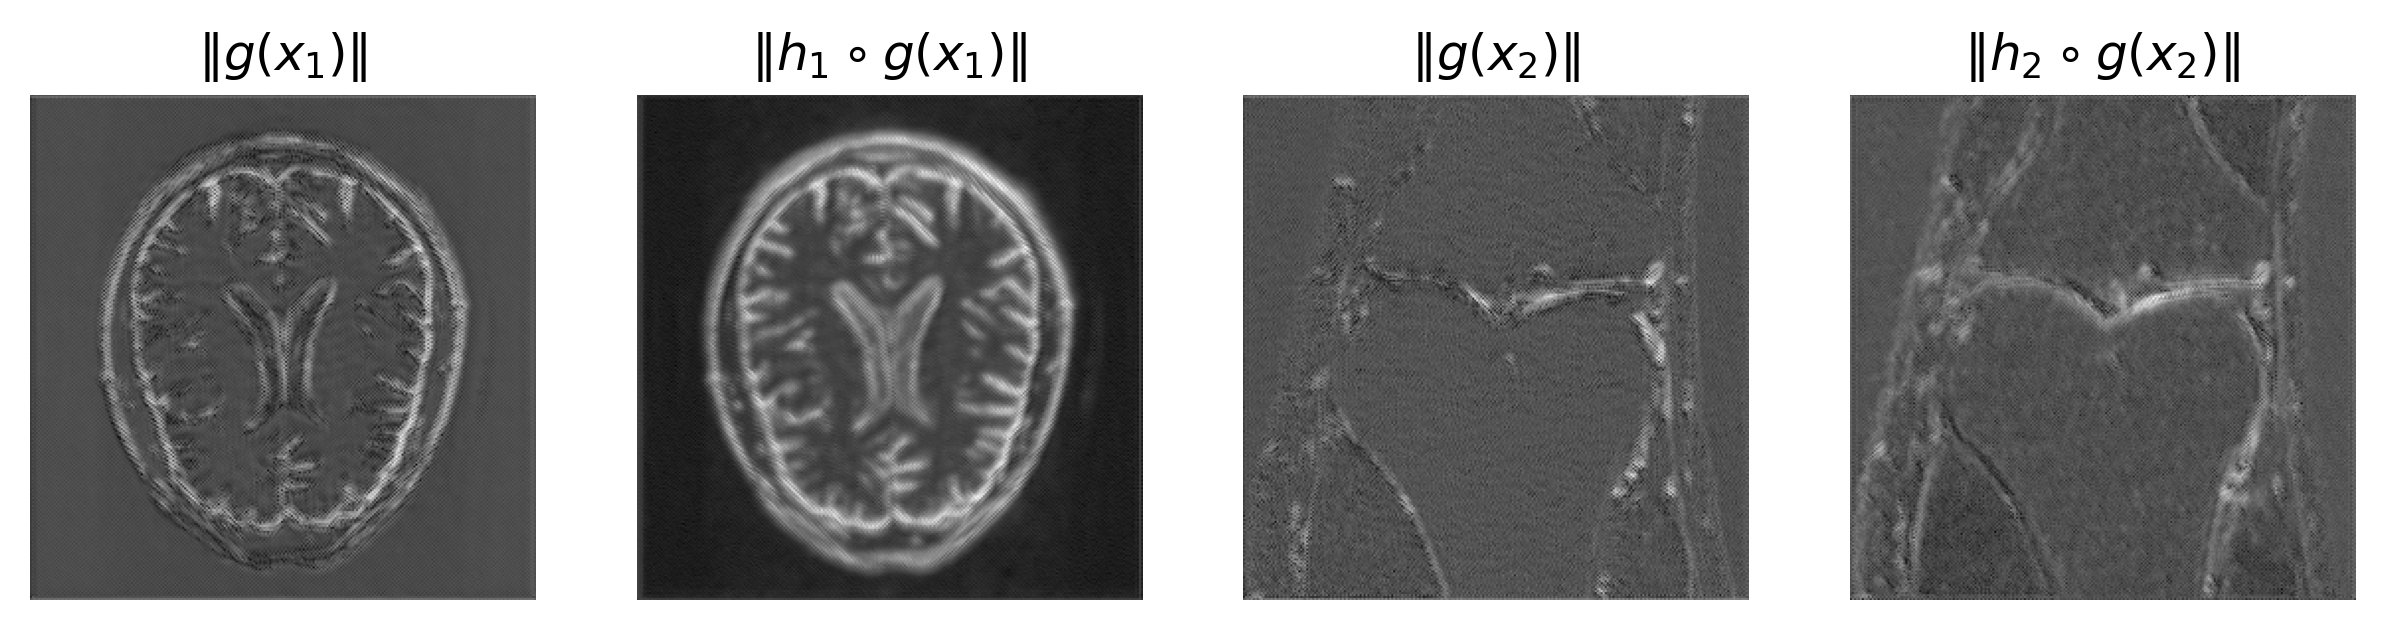

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), dpi=300)

ax[0].imshow(np.abs(g1[-1][-1][0].sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5, cmap='gray')
ax[1].imshow(np.abs(hg1[-1][0].sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5, cmap='gray')
ax[2].imshow(np.abs(g2[-1][-1][0].sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5, cmap='gray')
ax[3].imshow(np.abs(hg2[-1][0].sum(dim=0, keepdim=True).squeeze().cpu().detach().numpy())**0.5, cmap='gray')

ax[0].set_title('$\|g(x_1)\|$')
ax[1].set_title('$\|h_1\circ g(x_1)\|$')
ax[2].set_title('$\|g(x_2)\|$')
ax[3].set_title('$\|h_2\circ g(x_2)\|$')

for a in ax:
    a.axis('off')
    
# save figure
plt.savefig('figures/universal.pdf', bbox_inches='tight', dpi=300)

In [51]:
print("g1 min max:", torch.abs(g1[-1][-1][0]).min().cpu(), torch.abs(g1[-1][-1][0]).max().cpu())
print("g2 min max", torch.abs(g2[-1][-1][0]).min().cpu(), torch.abs(g2[-1][-1][0]).max().cpu())
print("g11 min max", torch.abs(g11[-1][-1][0]).min().cpu(), torch.abs(g11[-1][-1][0]).max().cpu())
print("g22 min max", torch.abs(g22[-1][-1][0]).min().cpu(), torch.abs(g22[-1][-1][0]).max().cpu())

g1 min max: tensor(2.4893e-05) tensor(0.3726)
g2 min max tensor(2.1809e-05) tensor(0.3041)
g11 min max tensor(1.1803e-05) tensor(0.1350)
g22 min max tensor(1.0095e-05) tensor(0.1741)


# CKA
To calculate CKA, we need a lot more samples, probably an entire dataset to actually see what's happening

In [138]:
batch_size = 2

brain_dataset_train = anatomy_data('data/brain/brain_singlecoil_train.mat', acc=5, n=800)
brain_loader_train = DataLoader(brain_dataset_train, batch_size=batch_size, shuffle=False)

knee_dataset_train = anatomy_data('data/knee/knee_singlecoil_train.mat', acc=5, n=800)
knee_loader_train = DataLoader(knee_dataset_train, batch_size=batch_size, shuffle=True)

In [139]:
len(brain_loader_train)

400

In [152]:
import torchvision.transforms as T
transform = T.Resize(size=(64,64))

In [155]:
all_g11 = [[] for i in range(15)]
all_g1 = [[] for i in range(15)]

for i, data in enumerate(brain_loader_train):
    brain_im_und, brain_k_und, brain_mask, brain_img_gnd, brain_k_gnd = data
    brain_im_und = brain_im_und.to(device)
    brain_k_und = brain_k_und.to(device)
    brain_mask = brain_mask.to(device)
    brain_img_gnd = brain_img_gnd.to(device)
    brain_k_gnd = brain_k_gnd.to(device)
    
    if (i+1) % 10 == 0:
        print(i+1)
    
    with torch.no_grad():
        _, g11 = model1(brain_im_und.to(device), brain_k_und.to(device), brain_mask.to(device))
        _, g1, hg1 = model(brain_im_und.to(device), brain_k_und.to(device), brain_mask.to(device), anatomies[0])
        
        for i in range(15):
            for j in range(4):
                feat11 = torch.abs(torch.square(g11[i][j]).sum(dim=1, keepdim=True))
                feat11 = transform(feat11).flatten(1)
                
                feat1 = torch.abs(torch.square(g1[i][j]).sum(dim=1, keepdim=True))
                feat1 = transform(feat1).flatten(1)
                all_g11[i].append(feat11)
                all_g1[i].append(feat1)
            
        
        # print(g11[-1][-1].shape, g22[-1][-1].shape, g1[-1][-1].shape)
        
        
        
        # break

/home/dingchi/Apps/anaconda3/envs/universe/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400


In [163]:
all_g22 = [[] for i in range(15)]
all_g2 = [[] for i in range(15)]

for i, data in enumerate(knee_loader_train):
    knee_im_und, knee_k_und, knee_mask, knee_img_gnd, knee_k_gnd = data
    knee_im_und = knee_im_und.to(device)
    knee_k_und = knee_k_und.to(device)
    knee_mask = knee_mask.to(device)
    knee_img_gnd = knee_img_gnd.to(device)
    knee_k_gnd = knee_k_gnd.to(device)
    
    if (i+1) % 10 == 0:
        print(i+1)
    
    with torch.no_grad():
        _, g22 = model2(knee_im_und.to(device), knee_k_und.to(device), knee_mask.to(device))
        _, g2, hg2 = model(knee_im_und.to(device), knee_k_und.to(device), knee_mask.to(device), anatomies[1])
        
        for i in range(15):
            for j in range(4):
                feat22 = torch.abs(torch.square(g22[i][j]).sum(dim=1, keepdim=True))
                feat22 = transform(feat22).flatten(1)
                
                feat2 = torch.abs(torch.square(g2[i][j]).sum(dim=1, keepdim=True))
                feat2 = transform(feat2).flatten(1)
                all_g22[i].append(feat22)
                all_g2[i].append(feat2)
                

/home/dingchi/Apps/anaconda3/envs/universe/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400


In [186]:
for i in range(15):
    print("phase", i+1)
    print("cka between g(x1) and g1(x1)", cuda_cka.kernel_CKA(torch.cat(all_g1[i]), torch.cat(all_g11[i])).item())

phase 1
cka between g(x1) and g1(x1) 0.5971893072128296
phase 2
cka between g(x1) and g1(x1) 0.5870822072029114
phase 3


cka between g(x1) and g1(x1) 0.6025614142417908
phase 4
cka between g(x1) and g1(x1) 0.6032066345214844
phase 5
cka between g(x1) and g1(x1) 0.5998280048370361
phase 6
cka between g(x1) and g1(x1) 0.6003323197364807
phase 7
cka between g(x1) and g1(x1) 0.6020931601524353
phase 8
cka between g(x1) and g1(x1) 0.5980673432350159
phase 9
cka between g(x1) and g1(x1) 0.6003395318984985
phase 10
cka between g(x1) and g1(x1) 0.5994116067886353
phase 11
cka between g(x1) and g1(x1) 0.6002220511436462
phase 12
cka between g(x1) and g1(x1) 0.6007099151611328
phase 13
cka between g(x1) and g1(x1) 0.6005122661590576
phase 14
cka between g(x1) and g1(x1) 0.5999367237091064
phase 15
cka between g(x1) and g1(x1) 0.6007223725318909


In [187]:
for i in range(15):
    print("phase", i+1)
    print("cka between g(x2) and g2(x2)", cuda_cka.kernel_CKA(torch.cat(all_g2[i]), torch.cat(all_g22[i])).item())

phase 1
cka between g(x2) and g2(x2) 0.522521436214447
phase 2
cka between g(x2) and g2(x2) 0.5247589945793152
phase 3
cka between g(x2) and g2(x2) 0.5291882157325745
phase 4
cka between g(x2) and g2(x2) 0.5293053388595581
phase 5
cka between g(x2) and g2(x2) 0.5294250845909119
phase 6
cka between g(x2) and g2(x2) 0.5271354913711548
phase 7
cka between g(x2) and g2(x2) 0.5287454724311829
phase 8
cka between g(x2) and g2(x2) 0.5292982459068298
phase 9
cka between g(x2) and g2(x2) 0.529999315738678
phase 10
cka between g(x2) and g2(x2) 0.5301471948623657
phase 11
cka between g(x2) and g2(x2) 0.530197262763977
phase 12
cka between g(x2) and g2(x2) 0.5300601124763489
phase 13
cka between g(x2) and g2(x2) 0.5304017066955566
phase 14
cka between g(x2) and g2(x2) 0.5306620001792908
phase 15
cka between g(x2) and g2(x2) 0.5307082533836365


In [143]:
x = torch.concat([g11[-1][-1], g22[-1][-1], g1[-1][-1]], dim=0)
print(x.shape)

torch.Size([6, 16, 256, 256])
